In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, f1_score, roc_auc_score, precision_score, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, LabelBinarizer
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklift.viz import plot_uplift_curve

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

from sklift.models import ClassTransformation
from sklift.models import TwoModels

from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.sample(5, random_state=12)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
4107,2,149.82,1,0,Surburban,1,Web,No Offer,0
43930,12,98.28,1,0,Urban,1,Phone,Discount,0
30369,9,434.25,1,0,Urban,1,Phone,Buy One Get One,0
61339,2,41.08,1,0,Urban,0,Web,Discount,0
56686,2,40.31,1,0,Urban,1,Phone,No Offer,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


### Преобразовываем offer и conversion:

In [4]:
df.rename(columns={'conversion': 'target'}, inplace=True)
df.rename(columns={'offer': 'treatment'}, inplace=True)

In [5]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [6]:
df.loc[df["treatment"] == "Buy One Get One", "treatment"] = 1
df.loc[df["treatment"] == "Discount", "treatment"] = 1
df.loc[df["treatment"] == "No Offer", "treatment"] = 0
df = df.astype({'treatment': np.int8})
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### Делаем dummies для zip_code и channel:

In [7]:
df = pd.get_dummies(df, columns = ['zip_code'])
df = pd.get_dummies(df, columns = ['channel'])

### Делаем Бокс-Кокс для 'history':

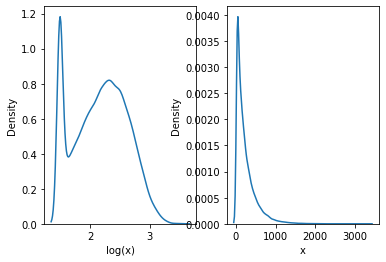

In [8]:
plt.subplot(1,2,1)
sns.kdeplot(np.log10(df['history'].values+1))
plt.xlabel('log(x)')
plt.subplot(1,2,2)
sns.kdeplot((df['history'].values+1))
plt.xlabel('x')
plt.show()

параметр для преобразования Бокса-Кокса:  -0.0005526707350174104


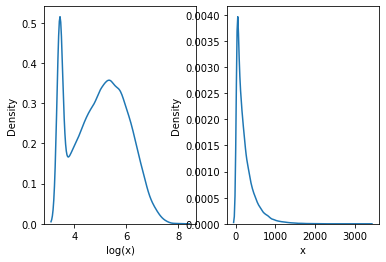

In [9]:
x_log, lyamb = stats.boxcox(  df['history']+1)

print('параметр для преобразования Бокса-Кокса: ',lyamb)
plt.subplot(1,2,1)
sns.kdeplot(x_log)
plt.xlabel('log(x)')
plt.subplot(1,2,2)
sns.kdeplot((df['history'].values))
plt.xlabel('x')
plt.show()

Text(0.5, 1.0, 'box_Cox')

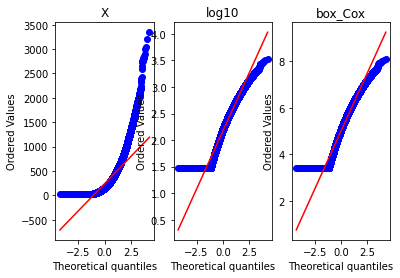

In [10]:
fig1, (ax1, ax2, ax3) = plt.subplots(1,3)

p3 = stats.probplot(x_log, dist=stats.norm, plot=ax3)
p1 = stats.probplot(df['history'], dist=stats.norm, plot=ax1)
p2 = stats.probplot(np.log10(df['history']), dist=stats.norm, plot=ax2)
ax1.set_title('X')
ax2.set_title('log10')
ax3.set_title('box_Cox')

In [11]:
df['history'] = x_log

### Финальный вид преобразованного датасета:

In [12]:
df.sample(5)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
35845,5,4.167271,1,0,0,0,1,0,1,0,0,1,0
27083,9,3.430409,1,0,0,1,1,0,0,1,0,1,0
20838,9,5.594595,1,0,1,1,0,1,0,0,1,0,0
51882,1,3.784761,0,1,1,1,0,0,0,1,0,0,1
38872,11,5.429785,0,1,0,1,0,0,0,1,0,0,1


### Разделение датасета:

In [13]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban',
                 'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web']

treatment = ['treatment']

target = ['target']

In [14]:
df_features = df[features]
df_train = df[treatment+target]
df_test = df.drop(features+treatment+target, axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [15]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

In [16]:
dict_rez = {'Solo Model':[], 'ClassTransform Model':[], 'Two Model':[]}

### Одна модель с признаком коммуникации (S-learner):

In [17]:
sm = SoloModel( CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit( X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_20 = uplift_at_k( y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k( y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
dict_rez['Solo Model'].append(sm_score_10)
dict_rez['Solo Model'].append(sm_score_20)

In [18]:
sm_score_20, sm_score_10

(0.08719104142243063, 0.09314527951524629)

### Трансформация классов:

In [19]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
dict_rez['ClassTransform Model'].append(ct_score_10)
dict_rez['ClassTransform Model'].append(ct_score_20)

In [20]:
ct_score_20, ct_score_10, 

(0.07157184202813599, 0.0728437744331509)

### Две независимые модели:

In [21]:
tm = TwoModels(    
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)   

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
dict_rez['Two Model'].append(tm_score_10)
dict_rez['Two Model'].append(tm_score_20)

In [22]:
tm_score_20, tm_score_10

(0.09149203790543181, 0.09238174354964818)

Solo Model


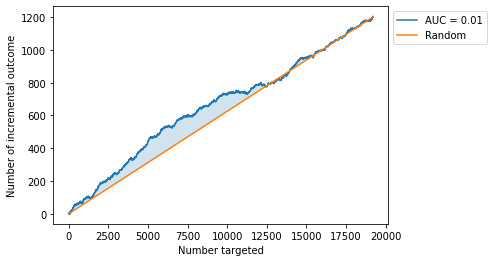

ClassTransform Model


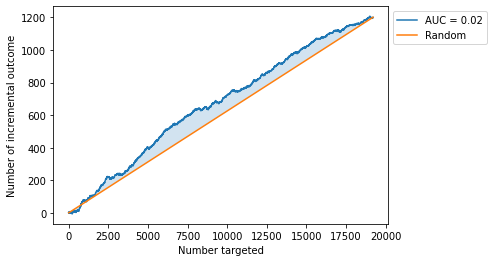

Two Model


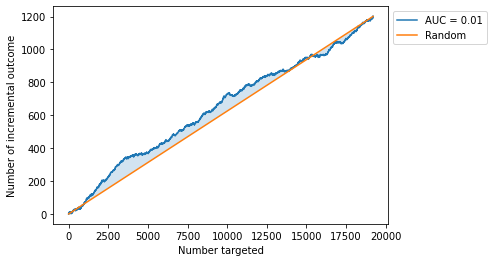

In [23]:
print('Solo Model')
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=False)
plt.show()

### Как видно по размерам площадей под кривыми, результат не очень хороший во всех случаях.

### Итоговая таблица:

In [24]:
df_rez = pd.DataFrame(dict_rez, index=['uplift@10%','uplift@20%'])
df_rez

,Solo Model,ClassTransform Model,Two Model
uplift@10%,0.093145,0.072844,0.092382
uplift@20%,0.087191,0.071572,0.091492


### Несмотря на то, что в статьях утверждается, что подход с двумя моделями достаточно слабый, именно он показал наилучший результат. Также логично, что выборка с меньшим количеством данных (10%) показывает чуть лучший результат.